### 0. Data Loading

In [ ]:
# prompt: load drive from google colab, force remount true

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1. Model Setup and DataLoading

In [ ]:
import torch
import torchvision
from torchvision.models.detection.retinanet import RetinaNetHead, RetinaNetClassificationHead, RetinaNetRegressionHead, RetinaNet_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import random
from PIL import Image
from torchvision import transforms
import torchvision.transforms as T


class TrafficSignDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file, delimiter=';', header=None,
                                      names=['filename', 'left', 'top', 'right', 'bottom', 'class'])
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        box_data = self.img_labels.iloc[idx, 1:5].values.astype(float)
        boxes = torch.tensor(box_data, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor([self.img_labels.iloc[idx, 5]], dtype=torch.int64)

        target = {'boxes': boxes, 'labels': label}

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

def get_transform(train):
    def transform(image, target):
        image = T.ToTensor()(image)
        if train and torch.rand(1) < 0.5:  # Random Horizontal Flip
            image = F.hflip(image)
            width = image.shape[-1]
            target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]

        return image, target
    return transform

def create_retinanet_model(num_classes):
    # Load a pre-trained RetinaNet with ResNet-50 backbone
    weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.retinanet_resnet50_fpn(weights=weights)

    # Replace the classification head
    num_anchors = model.head.classification_head.num_anchors
    model.head = RetinaNetHead(
        model.backbone.out_channels,
        num_anchors,
        num_classes
    )
    return model

annotations_file = '/content/drive/MyDrive/GTD/gt.txt'
img_dir = '/content/drive/MyDrive/GTD/train'

train_dataset = TrafficSignDataset(annotations_file, img_dir, get_transform(train=True))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Define the model
num_classes = 44  # example including background
model = create_retinanet_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


### 2. Training

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(data_loader, desc="Training Epoch"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)

# Assume 'model' and 'train_loader' have been defined as in the previous snippet
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

torch.save(model.state_dict(), f'/content/drive/MyDrive/GTD/retinanet_{epoch}.pth')
print('Model Saved Successfully')

Training Epoch: 100%|██████████| 213/213 [07:21<00:00,  2.07s/it]


Epoch 1, Loss: 1.5526


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 2, Loss: 1.2755


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 3, Loss: 0.9729


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 4, Loss: 0.8957


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 5, Loss: 0.8657


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 6, Loss: 0.8042


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 7, Loss: 0.7724


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 8, Loss: 0.7428


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 9, Loss: 0.7160


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 10, Loss: 0.6888


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 11, Loss: 0.7131


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 12, Loss: 0.6693


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 13, Loss: 0.6384


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.61it/s]


Epoch 14, Loss: 0.5979


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 15, Loss: 0.6123


Training Epoch: 100%|██████████| 213/213 [02:12<00:00,  1.61it/s]


Epoch 16, Loss: 0.5801


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.61it/s]


Epoch 17, Loss: 0.5623


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 18, Loss: 0.5443


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 19, Loss: 0.5324


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 20, Loss: 0.5149


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 21, Loss: 0.5100


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 22, Loss: 0.5019


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 23, Loss: 0.4872


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 24, Loss: 0.4732


Training Epoch: 100%|██████████| 213/213 [02:11<00:00,  1.62it/s]


Epoch 25, Loss: 0.4636


### 3. Evaluation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
from tqdm import tqdm
import pandas as pd

# Assuming the dataset class and transform function have already been defined

# Load the test dataset
test_dataset = TrafficSignDataset(
    annotations_file='/content/drive/MyDrive/GTD/gt.txt',
    img_dir='/content/drive/MyDrive/GTD/train',
    transforms=get_transform(train=False)
)

# DataLoader for testing
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# Load the trained model
num_classes = 44  # example including background
model = create_retinanet_model(num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/GTD/retinanet_24.pth'))  # Load your saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def evaluate(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou, total_tp, total_fn, count = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                if 'boxes' not in targets[i]:
                    continue

                target_boxes = targets[i]['boxes']
                if output['boxes'].nelement() == 0 or target_boxes.nelement() == 0:
                    continue

                iou = box_iou(output['boxes'], target_boxes)
                max_iou, _ = iou.max(dim=1)
                total_tp += (max_iou > iou_threshold).sum().item()
                total_fn += (max_iou <= iou_threshold).sum().item()
                total_iou += iou.diag().sum().item()
                count += output['boxes'].size(0)

        avg_iou = total_iou / count if count > 0 else 0
        precision = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
        recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        print(f"\nAverage IoU: {avg_iou:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1_score:.2f}")

# Evaluate the model
evaluate(model, test_loader, device)


Evaluating: 100%|██████████| 213/213 [01:04<00:00,  3.31it/s]


Average IoU: 0.01
Precision: 0.42
Recall: 0.42
F1 Score: 0.42


### 4. Prediction & Visualization

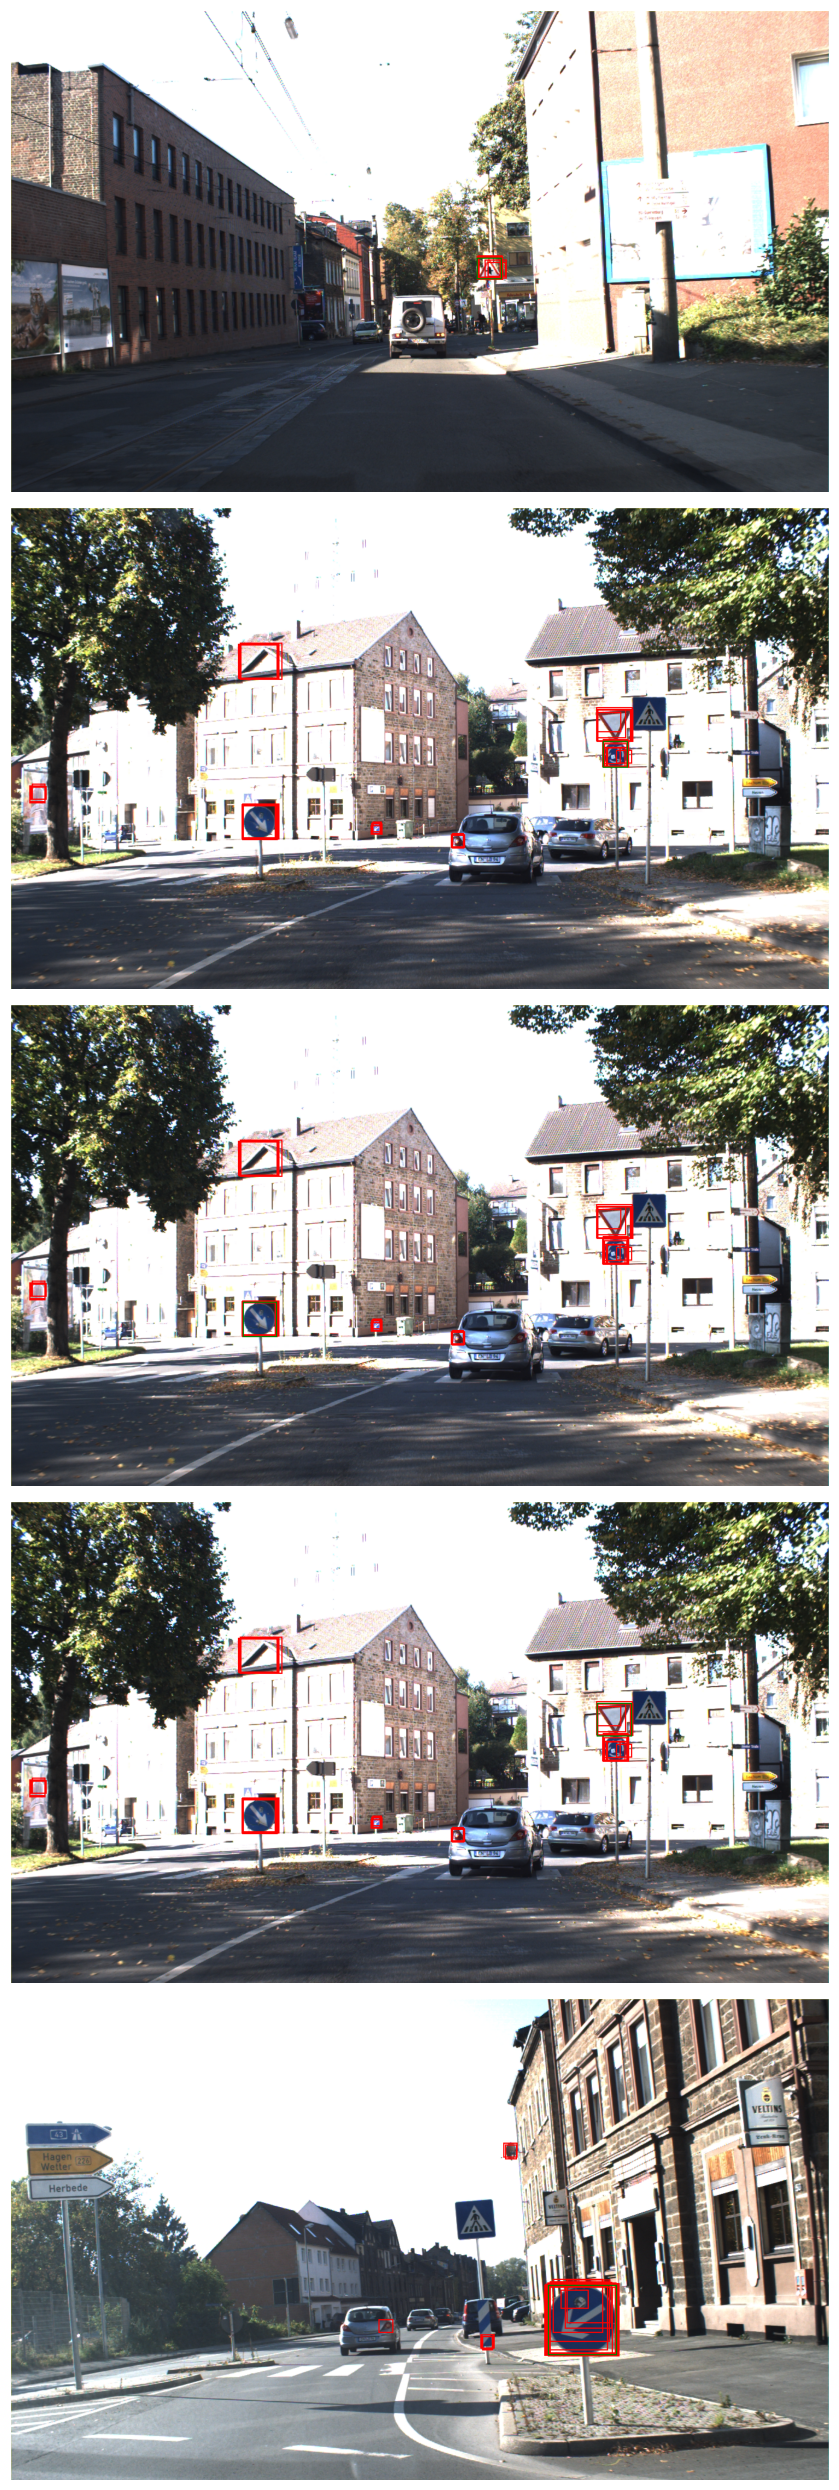

In [ ]:
import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from copy import deepcopy

def visualize_predictions(model, dataset, device, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_images, 1, figsize=(10, 5 * num_images))  # Adjusted to column-wise layout
    with torch.no_grad():
        for idx, (image, target) in enumerate(dataset):
            if idx == num_images:
                break

            # Move image to device
            image = image.to(device)
            output = model([image])[0]

            # Convert image back to CPU
            image = image.cpu()
            output_boxes = output['boxes'].cpu()
            target_boxes = target['boxes'].cpu()

            # Convert image to PIL and copy it to avoid altering original
            image_pil = deepcopy(F.to_pil_image(image))
            draw = ImageDraw.Draw(image_pil)

            # Draw the predicted boxes
            for box in output_boxes:
                draw.rectangle(box.tolist(), outline='red', width=2)

            # Draw the ground truth boxes
            for box in target_boxes:
                draw.rectangle(box.tolist(), outline='green', width=2)

            ax = axes[idx]
            ax.imshow(image_pil)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_images=5)
